In [17]:
import sys
print(sys.version)
sys.path.append("../tools")

3.5.3 |Intel Corporation| (default, Apr 27 2017, 18:08:47) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [3]:
from __future__ import print_function

In [4]:
import random

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

/opt/intel/intelpython3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
import pickle

In [8]:
import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
with open("final_project_dataset.pkl", "rb") as data_file:
    dataset = pickle.load(data_file)

In [26]:
import pandas as pd

In [29]:
df = pd.DataFrame(dataset).transpose()

In [57]:
len(df[df['poi']==0])

128

In [47]:
for col in df:
    print(col, ',', sum(df[col]=='NaN'))

bonus , 64
deferral_payments , 107
deferred_income , 97
director_fees , 129
email_address , 35
exercised_stock_options , 44
expenses , 51
from_messages , 60
from_poi_to_this_person , 60
from_this_person_to_poi , 60
loan_advances , 142
long_term_incentive , 80
other , 53
poi , 0
restricted_stock , 36
restricted_stock_deferred , 128
salary , 51
shared_receipt_with_poi , 60
to_messages , 60
total_payments , 21
total_stock_value , 20


### Task 1: Select what features you'll use.

In [58]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

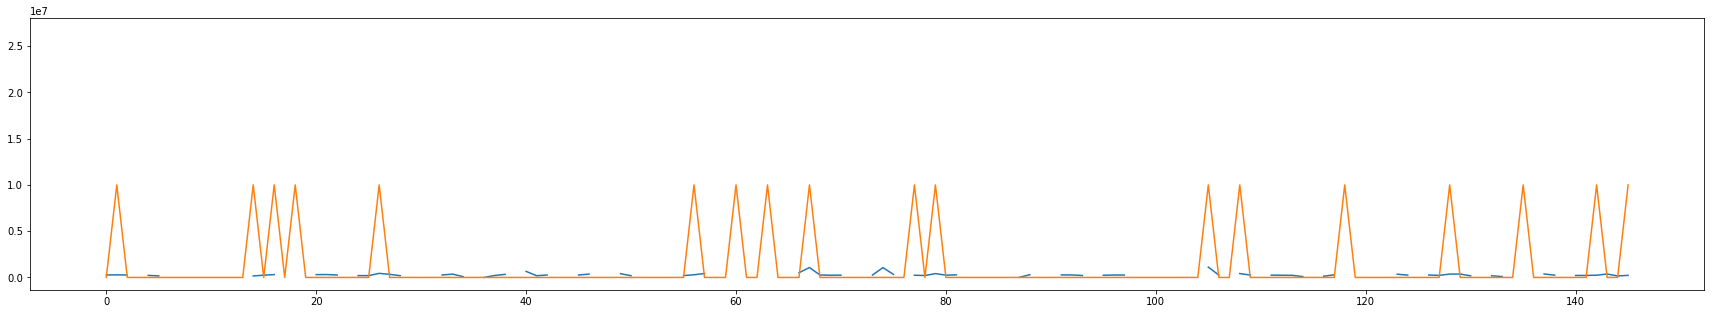

In [59]:
# brief check for outliers
salaries, pois = [], []
for k, v in dataset.items():
    salaries.append(v['salary'])
    pois.append(v['poi'] * 10000000)  # multiply for visual scale
plt.figure(figsize=(30,5))
plt.plot(salaries)
plt.plot(pois)
plt.show()

### Task 2: Remove outliers

In [60]:
# extreme outlier with salary 25M +
# check it's key name
for k, v in dataset.items():
    if v['salary'] != 'NaN' and v['salary'] > 10000000: 
        print(k)

TOTAL


In [61]:
# remove "TOTAL" row from the dataset
del dataset['TOTAL']

In [62]:
# get all dict keys
all_features = list(list(dataset.items())[0][1].keys())

In [63]:
print(all_features)

['restricted_stock', 'total_payments', 'exercised_stock_options', 'salary', 'deferred_income', 'long_term_incentive', 'other', 'email_address', 'total_stock_value', 'from_messages', 'to_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'expenses', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'bonus', 'loan_advances', 'poi', 'deferral_payments', 'director_fees']


In [64]:
# email address is pretty much useless
del all_features[all_features.index('email_address')]

### Task 3: Create new feature(s)

In [65]:
# a feature to represent ratio of person's correspondence with poi to their total correspondence
for k, v in dataset.items():
    if any([v['from_poi_to_this_person']=='NaN', v['from_this_person_to_poi']=='NaN', v['to_messages']=='NaN', v['from_messages']=='NaN']):
        v['interaction_with_poi'] = 'NaN'
    else:
        v['interaction_with_poi'] = (v['from_poi_to_this_person'] + v['from_this_person_to_poi']) / (v['to_messages'] + v['from_messages'])

In [66]:
# ratio of deferral payments to total payments
for k, v in dataset.items():
    if any([v['deferral_payments']=='NaN', v['total_payments']=='NaN']):
        v['payments_ratio'] = 'NaN'
    else:
        v['payments_ratio'] = v['deferral_payments'] / v['total_payments']

In [67]:
# ratio of income to total payments
for k, v in dataset.items():
    if any([v['salary']=='NaN', v['total_payments']=='NaN', v['bonus']=='NaN']):
        v['salary_payments_ratio'] = 'NaN'
    else:
        v['salary_payments_ratio'] = v['total_payments'] / v['salary'] + v['bonus']

In [68]:
# once again pick all features
all_features = list(list(dataset.items())[0][1].keys())
del all_features[all_features.index('email_address')]

In [69]:
# a line to ensure poi will be in first place so lables and features could be succesfully formed with featureFormat
my_features = ['poi'] + [f for f in all_features if f != 'poi']

In [70]:
print(my_features)

['poi', 'restricted_stock', 'total_payments', 'salary', 'deferred_income', 'other', 'total_stock_value', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'restricted_stock_deferred', 'bonus', 'long_term_incentive', 'to_messages', 'director_fees', 'from_messages', 'loan_advances', 'salary_payments_ratio', 'payments_ratio', 'interaction_with_poi', 'from_this_person_to_poi', 'deferral_payments', 'expenses', 'exercised_stock_options']


In [133]:
data = featureFormat(dataset, my_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [134]:
# normalize
features = preprocessing.scale(features)

In [135]:
# check for best features using sklearn's SelectKBest
# pick 5 features
k_best = SelectKBest(k=4)
k_best.fit(features, labels)

SelectKBest(k=4, score_func=<function f_classif at 0x7efc1535b268>)

In [136]:
# create a new feature list
feature_list = ['poi']
for f in sorted(zip(k_best.scores_, k_best.get_support(), my_features[1:]), reverse=True):
    print(f[1], f[0], f[2])
    if f[1]:
        feature_list.append(f[2])

True 25.0975415287 exercised_stock_options
True 24.4676540475 total_stock_value
True 21.0600138991 salary_payments_ratio
True 21.0600017075 bonus
False 18.575703268 salary
False 11.5955476597 deferred_income
False 10.0724545294 long_term_incentive
False 9.34670079105 restricted_stock
False 8.86672153711 total_payments
False 8.74648553213 shared_receipt_with_poi
False 7.24273039654 loan_advances
False 6.23420114051 expenses
False 5.51850554381 interaction_with_poi
False 5.34494152315 from_poi_to_this_person
False 4.2049708583 other
False 2.42650812724 from_this_person_to_poi
False 2.10765594328 director_fees
False 1.69882434858 to_messages
False 1.33811668902 payments_ratio
False 0.21705893034 deferral_payments
False 0.164164498234 from_messages
False 0.0649843117237 restricted_stock_deferred


### Task 4: Try a varity of classifiers

In [137]:
clf = GaussianNB()
test_classifier(clf, dataset, feature_list)

GaussianNB(priors=None)
	Accuracy: 0.84208	Precision: 0.48191	Recall: 0.35300	F1: 0.40750	F2: 0.37295
	Total predictions: 13000	True positives:  706	False positives:  759	False negatives: 1294	True negatives: 10241



In [138]:
clf = LogisticRegression()
test_classifier(clf, dataset, feature_list)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.63215	Precision: 0.02265	Recall: 0.03300	F1: 0.02686	F2: 0.03024
	Total predictions: 13000	True positives:   66	False positives: 2848	False negatives: 1934	True negatives: 8152



In [139]:
clf = RandomForestClassifier()
test_classifier(clf, dataset, feature_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.84823	Precision: 0.51077	Recall: 0.32000	F1: 0.39348	F2: 0.34583
	Total predictions: 13000	True positives:  640	False positives:  613	False negatives: 1360	True negatives: 10387



In [140]:
clf = MLPClassifier()
test_classifier(clf, dataset, feature_list)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
	Accuracy: 0.58554	Precision: 0.14664	Recall: 0.35150	F1: 0.20695	F2: 0.27474
	Total predictions: 13000	True positives:  703	False positives: 4091	False negatives: 1297	True negatives: 6909



In [141]:
clf = KNeighborsClassifier()
test_classifier(clf, dataset, feature_list)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.87846	Precision: 0.80172	Recall: 0.27900	F1: 0.41395	F2: 0.32084
	Total predictions: 13000	True positives:  558	False positives:  138	False negatives: 1442	True negatives: 10862



In [142]:
clf = GradientBoostingClassifier()
test_classifier(clf, dataset, feature_list)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
	Accuracy: 0.81585	Precision: 0.38493	Recall: 0.32950	F1: 0.35506	F2: 0.33927
	Total predictions: 13000	True positives:  659	False positives: 1053	False negatives: 1341	True negatives: 9947



In [143]:
clf = AdaBoostClassifier()
test_classifier(clf, dataset, feature_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.81308	Precision: 0.37784	Recall: 0.33250	F1: 0.35372	F2: 0.34068
	Total predictions: 13000	True positives:  665	False positives: 1095	False negatives: 1335	True negatives: 9905



### Task 5: Tune your classifier to achieve better than .3 precision and recall 

In [36]:
# prepare the data for manual testing
data = featureFormat(dataset, feature_list, sort_keys = True)
y, X = targetFeatureSplit(data)

In [37]:
# create parameter array - list of tuples with two numbers, representing probabilites, which sum up to 1
priors = [(round(i / 20., 2), round(1 - (i / 20.), 2),) for i in range(1, 20)]

In [38]:
print(priors)

[(0.05, 0.95), (0.1, 0.9), (0.15, 0.85), (0.2, 0.8), (0.25, 0.75), (0.3, 0.7), (0.35, 0.65), (0.4, 0.6), (0.45, 0.55), (0.5, 0.5), (0.55, 0.45), (0.6, 0.4), (0.65, 0.35), (0.7, 0.3), (0.75, 0.25), (0.8, 0.2), (0.85, 0.15), (0.9, 0.1), (0.95, 0.05)]


In [39]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [40]:
parameters = {'priors': priors}

In [41]:
scores = ['precision', 'recall']

In [42]:
# perform GridSearchCV - results may vary due to random nature
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    clf = GridSearchCV(GaussianNB(), parameters, cv=10, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print("\n\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

# Tuning hyper-parameters for precision


/home/me/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
{'priors': (0.9, 0.1)}
Grid scores on development set:
0.610 (+/-0.349) for {'priors': (0.05, 0.95)}
0.576 (+/-0.370) for {'priors': (0.1, 0.9)}
0.576 (+/-0.370) for {'priors': (0.15, 0.85)}
0.586 (+/-0.376) for {'priors': (0.2, 0.8)}
0.595 (+/-0.384) for {'priors': (0.25, 0.75)}
0.626 (+/-0.441) for {'priors': (0.3, 0.7)}
0.626 (+/-0.440) for {'priors': (0.35, 0.65)}
0.627 (+/-0.438) for {'priors': (0.4, 0.6)}
0.627 (+/-0.438) for {'priors': (0.45, 0.55)}
0.627 (+/-0.438) for {'priors': (0.5, 0.5)}
0.627 (+/-0.438) for {'priors': (0.55, 0.45)}
0.627 (+/-0.438) for {'priors': (0.6, 0.4)}
0.627 (+/-0.438) for {'priors': (0.65, 0.35)}
0.627 (+/-0.438) for {'priors': (0.7, 0.3)}
0.627 (+/-0.438) for {'priors': (0.75, 0.25)}
0.650 (+/-0.485) for {'priors': (0.8, 0.2)}
0.650 (+/-0.485) for {'priors': (0.85, 0.15)}
0.680 (+/-0.521) for {'priors': (0.9, 0.1)}
0.680 (+/-0.521) for {'priors': (0.95, 0.05)}


Detailed classification report:

The mode

#### However In the real world scenario predict_proba sould be used for classifying classes with different error significance

In [129]:
clf = GaussianNB(priors=(0.25, 0.75))
test_classifier(clf, dataset, feature_list)

GaussianNB(priors=(0.25, 0.75))
	Accuracy: 0.80869	Precision: 0.38487	Recall: 0.40700	F1: 0.39563	F2: 0.40237
	Total predictions: 13000	True positives:  814	False positives: 1301	False negatives: 1186	True negatives: 9699



In [44]:
dump_classifier_and_data(clf, dataset, feature_list)

/home/me/uw/ud120-projects/final_project


#### A pipeline would look like this

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

In [46]:
from sklearn.metrics import precision_score, recall_score

In [47]:
anova_filter = SelectKBest(f_regression, k=5)
clf = GaussianNB()
anova_gnb = Pipeline([('anova', anova_filter), ('gnb', clf)])
anova_gnb.set_params(gnb__priors=(0.25, 0.75))

Pipeline(steps=[('anova', SelectKBest(k=5, score_func=<function f_regression at 0x7fc3879aa668>)), ('gnb', GaussianNB(priors=(0.25, 0.75)))])

In [48]:
test_classifier(anova_gnb, dataset, feature_list)

Pipeline(steps=[('anova', SelectKBest(k=5, score_func=<function f_regression at 0x7fc3879aa668>)), ('gnb', GaussianNB(priors=(0.25, 0.75)))])
	Accuracy: 0.81246	Precision: 0.38906	Recall: 0.38400	F1: 0.38651	F2: 0.38500
	Total predictions: 13000	True positives:  768	False positives: 1206	False negatives: 1232	True negatives: 9794

